# Install TF API Detection

https://github.com/trekhleb/links-detector/blob/master/articles/printed_links_detection/printed_links_detection.ru.md#user-content--%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%B0%D0%B2%D0%BB%D0%B8%D0%B2%D0%B0%D0%B5%D0%BC-object-detection-api

In [13]:
# !git clone --depth 1 https://github.com/tensorflow/models
# !git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [15]:
# cd ./models/research
# !protoc object_detection/protos/*.proto --python_out=.

"protoc" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## Resize and Augmentation

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook

okey shape:  (1773, 1773, 3)
ashan shape:  (3000, 3000, 3)


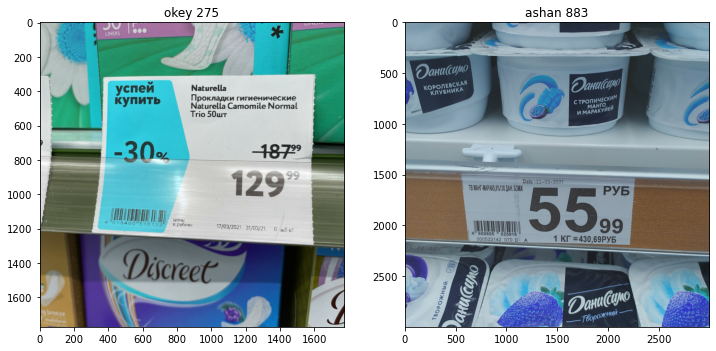

In [2]:
okey = os.listdir('data/okey_origin')
okey  = ['data/okey_origin/'+name for name in okey]
ashan = os.listdir('data/ashan_origin')
ashan  = ['data/ashan_origin/'+name for name in ashan]

print('okey shape: ',cv2.imread(okey[0]).shape )
print('ashan shape: ',cv2.imread(ashan[0]).shape )

plt.figure(figsize = (12,12))
plt.subplot(121)
plt.title(f'okey {len(okey)}')
plt.imshow((cv2.imread(okey[0])))
plt.subplot(122)
plt.title(f'ashan { len(ashan)}')
plt.imshow((cv2.imread(ashan[0])))

Resize 640x640 and augmentation

In [3]:
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.001)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.9, 1.03), "y": (0.9, 1.03)},# by 90% -103 degrees
        translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)},
        rotate=(-15, 15),
        shear=(-2,2)#Shear images by -16 to 16 degrees
    )
], random_order=True)

Для каждой фотографии 4 раза применим аугментацию

In [5]:
num = 0
for augmet_count in range(4):
    random.shuffle(okey)
    for i in tqdm_notebook(range(len(okey))):
        im = cv2.imread(okey[i])
        im = cv2.resize(im, (640, 640))
        cr = seq(images=np.array([im]))[0]        
        cv2.imwrite(f'data/data/{num}.jpg',cr)
        num+=1

  0%|          | 0/1158 [00:00<?, ?it/s]

  0%|          | 0/1158 [00:00<?, ?it/s]

  0%|          | 0/1158 [00:00<?, ?it/s]

  0%|          | 0/1158 [00:00<?, ?it/s]

# label xml to csv

Конвертируем xml файлы в csv

In [4]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [5]:
def xml_to_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
def xml_to_csv(image_path, save_path):
#     image_path = os.path.join(os.getcwd(), 'data/data_labels')
    print(image_path)
    xml_df = xml_to_df(image_path)
    xml_df.to_csv(save_path, index=None)
    print('Successfully converted xml to csv.')

In [6]:
%%time
image_path = os.path.join(os.getcwd(), 'data/data_labels')
save_path = os.path.join(os.getcwd(), 'data/data_labels.csv')
xml_to_csv(image_path, save_path)

D:\mobileappocr\data/data_labels
Successfully converted xml to csv.
Wall time: 93.5 ms


In [7]:
label_csv = pd.read_csv('data/data_labels.csv')
print(label_csv.shape)
label_csv.head()

(838, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,107.jpg,640,640,price_tag,106,248,559,474
1,107.jpg,640,640,name,118,301,258,339
2,107.jpg,640,640,barcode,136,393,267,452
3,107.jpg,640,640,price,262,280,529,418
4,108.jpg,640,640,price_tag,32,228,523,473


## csv to tensorflow records

создаем .records файлы

In [8]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

In [9]:
def class_text_to_int(row_label):
    if row_label == 'price_tag':
        return 1
    elif row_label =='price':
        return 2
    elif row_label == 'barcode':
        return 3
    elif row_label == 'name':
        return 4
    else:
        None
def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]
def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

Создадим record файл

In [10]:
# path = 'data\\data'
writer = tf.io.TFRecordWriter(os.path.join(os.getcwd(), 'data\\train.record'))
path = os.path.join(os.getcwd(), 'data\\data')
examples = pd.read_csv('data\\data_labels.csv')
grouped = split(examples, 'filename')

for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
writer.close()